# Short-term Load Forecasting using LSTM


---



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Libraries

In [ ]:
import numpy as np
from math import sqrt
from pandas import read_csv
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from scipy.interpolate import make_interp_spline

from keras.callbacks import CSVLogger
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten
from keras.layers import RepeatVector
from keras.backend import dropout

from statsmodels.tsa.seasonal import seasonal_decompose

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Helper Functions

In [ ]:
# split  dataset into train, validate and test sets
def split_dataset(data):
	# split into train validation and test sets
	train, val, test = data[12:13932], data [13932:18300], data[18300:22716]
	# restructure into samples of daily data shape is [samples, hours, feature]
	train = np.array(np.split(train, len(train)/24))
	val = np.array(np.split(val, len(val)/24))
	test = np.array(np.split(test, len(test)/24))
	return train, val, test

# evaluate one or more daily forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each hour of the day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store in scores list
		scores.append(rmse)
  
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs (actual) and outputs (predicted) for training
def convert_train_val(train, n_input, n_out=24):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step of 1 hour
		in_start += 1
	return np.array(X), np.array(y)


# train the model
def build_model_LSTM(train, val, n_input):
	# Create training and validation sets
	train_x, train_y = convert_train_val(train, n_input)
	val_x, val_y = convert_train_val(val, n_input)
	# define parameters
	csv_logger = CSVLogger('LSTM_Model_Logger.log')
	verbose, epochs, batch_size = 0, 30, 384
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	nv_timesteps, nv_features, nv_outputs = val_x.shape[1], val_x.shape[2], val_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	val_y = val_y.reshape((val_y.shape[0], val.shape[1], 1))
 
	# define model
	model = Sequential()
	model.add(LSTM(100, activation='relu', input_shape=(n_timesteps, n_features)))
	model.add(Dense(100, activation='relu'))
	model.add(Dense(n_outputs))
	model.compile(loss='mse', optimizer='adam')
	print(model.summary())
	# fit network
	hist=model.fit(train_x, train_y, validation_data=(val_x, val_y),callbacks=[csv_logger], epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model, hist

# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = np.array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1] that is 1 sample, sample data size, one feature
	input_x = input_x.reshape((1, len(input_x), 1))
	# forecast the next hour
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

# evaluate model fits model using training and validation data, then conducts a walk forwad validation with the test data
def evaluate_model_LSTM(train, val, test, n_input):
	# fit model
	model, hist = build_model_LSTM(train, val, n_input)
	# history is a list of houry data
	history = [x for x in train]
	# walk-forward validation over each hour in test set
	predictions = list()
	for i in range(len(test)):
		# predict the hour
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next hour
		history.append(test[i, :])
	# evaluate predictions hours for each day
	predictions = np.array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores, hist, predictions

## Load Dataset

In [ ]:
dataset = read_csv('/content/drive/MyDrive/data_spatial_TotalKW.csv', header=0, 
                   infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])

#### Decompose data into trend, seasonality, and noise

<Figure size 432x288 with 0 Axes>

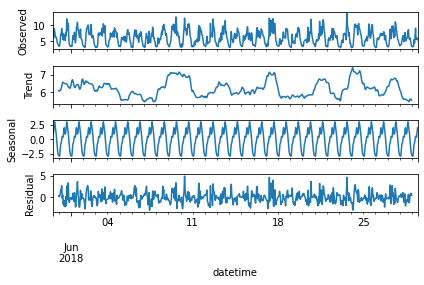

In [ ]:
fig1 = plt.gcf()
month = dataset.iloc[0:720]
decomp = seasonal_decompose(month, model='additive')
decomp.plot()
plt.show()
fig1.savefig('seasonal_decompose.pdf')

#### Normalization - normalize data using min-max scaling

In [ ]:
trans = MinMaxScaler()
dataset = trans.fit_transform(dataset)
tran_scale = trans.scale_

# split into train and test
train, val, test = split_dataset(dataset)
print('train size: ', train.shape)
print('valid size: ', val.shape)
print('test size : ', test.shape)

train size:  (580, 24, 1)
valid size:  (182, 24, 1)
test size :  (184, 24, 1)


#### Actual data

In [ ]:
N_actual= test[1:184] / tran_scale

#### Evaulate LSTM model and get scores

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 100)               10100     
                                                                 
 dense_1 (Dense)             (None, 24)                2424      
                                                                 
Total params: 53,324
Trainable params: 53,324
Non-trainable params: 0
_________________________________________________________________
None
rmse: [1.539] 0.5, 0.5, 0.5, 0.7, 1.1, 1.3, 1.4, 1.7, 1.9, 2.1, 2.6, 2.1, 1.9, 1.8, 1.8, 1.8, 2.3, 1.8, 1.4, 1.3, 1.1, 1.0, 0.8, 0.7


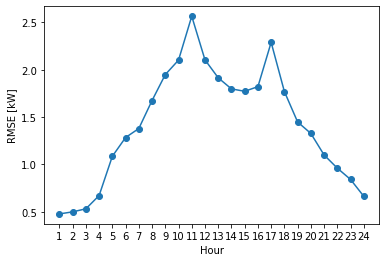

[1.53909131]
[0.47789566 0.49964765 0.53182154 0.67191743 1.0866498  1.28430137
 1.37959451 1.67508129 1.94870343 2.10161977 2.56491597 2.10463802
 1.91485243 1.79781541 1.77269079 1.82159419 2.28904248 1.77002335
 1.44870083 1.32751447 1.10035226 0.96112841 0.84174612 0.66385541]


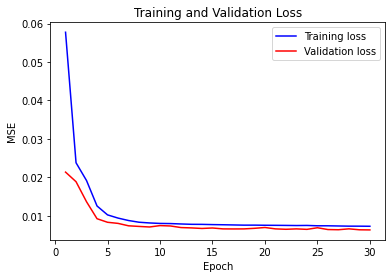

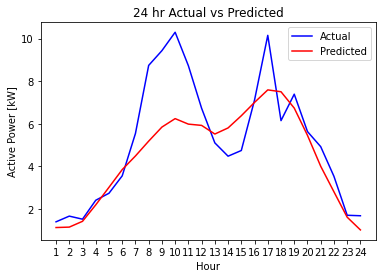

In [ ]:
n_input = 24
LSTM_score, LSTM_scores, hist, predictions_LSTM = evaluate_model_LSTM(train, val, test, n_input)
LSTM_score, LSTM_scores, predictions_LSTM = LSTM_score / tran_scale , LSTM_scores / tran_scale, predictions_LSTM / tran_scale
# summarize rmse scores
summarize_scores('rmse', LSTM_score, LSTM_scores)

# plot rmse scores
fig10 = plt.gcf()
hours = ['1', '2', '3', '4', '5', '6', '7','8', '9', '10', '11', '12','13', '14', '15', '16', '17', '18', '19','20', '21', '22', '23', '24' ]
plt.plot(hours, LSTM_scores, marker='o', label='lstm')
plt.xlabel("Hour")
plt.ylabel("RMSE [kW]")
plt.show()
fig10.savefig('rmse-LSTM.pdf')
print(LSTM_score)
print(LSTM_scores)

# plot Training and Validation Loss
fig11 = plt.gcf()
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()
fig11.savefig('train-val-loss.pdf')

# plot an example prediction for one day
fig12 = plt.gcf()
plt.plot(hours, N_actual[15], 'b', label='Actual')
plt.plot(hours, predictions_LSTM[15], 'r', label='Predicted')
plt.title('24 hr Actual vs Predicted')
plt.xlabel("Hour")
plt.ylabel("Active Power [kW]")
plt.legend()
plt.show()
fig12.savefig('predictions-LSTM.pdf')